In [1]:
import sys
sys.path.append("../") # go to parent dir

%load_ext autoreload
%autoreload 2

In [2]:
from evrp.utils.utilities import *
from evrp.utils.graph import draw_plain_graph, draw_graph
from evrp.utils.plot import plot_interactive_graph
from evrp.milp.tsp import TSP
from evrp.milp.vrptw import VRPTW
from evrp.milp.evrptw import EVRPTW

import pandas as pd
import numpy as np
from scipy.spatial import distance

import pprint

import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

import itertools

import networkx as nx

from pyomo.environ import *

from evrp.config.GLOBAL_CONFIG import *

pd.options.plotting.backend = "plotly"
pp = pprint.PrettyPrinter()

In [3]:
instance = 'c205c10_e'
fpath = 'config/test_instances/' + instance + '.csv'

In [69]:
del m.instance, m.results
m.instance = m.instance2.clone()
m.results = m.results2.copy()

In [70]:
# Initialize past solution
# Specify solver
opt = SolverFactory('gurobi', io_format='python')
# Solver options
solv_options = {'TimeLimit': 60*5}  # 'Symmetry': 2

# SAVE PAST MODEL RESULT
m.instance2 = m.instance.clone()
m.results2 = m.results.copy()

# CHANGE CONSTRAINTS
def constraint_energy_peak(instance, s, t):
    """Peak electric demand for each physical station s(i) ∈ S"""
    return instance.G[s, t] + sum(instance.xkappa[i, t] * instance.xp[i, t] for i in instance.Smap[s]) <= instance.xd[s]
m.instance.constraint_energy_peak = Constraint(m.instance.S, m.instance.T, rule=constraint_energy_peak)

# CHANGE OBJECTIVES
m.instance.del_component(m.instance.obj)  # Decativate the old objective
def new_obj(instance):
    return m.total_distance(instance) + m.C_fleet_capital_cost(instance) + m.cycle_cost(instance) + m.squeeze_cycle_cost(instance) + m.R_energy_arbitrage_revenue(instance) + m.R_peak_shaving_revenue(instance)
m.instance.obj = Objective(rule=new_obj, sense=minimize)

# Solve instance
m.results = opt.solve(m.instance, tee=True, warmstart=True, options=solv_options)

Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-21
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpyygddxpo.pyomo.lp
Reading time = 0.05 seconds
x1167: 616 rows, 1167 columns, 2188 nonzeros
Read MIP start from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpht2w3ggi.gurobi.mst
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 616 rows, 1167 columns and 2188 nonzeros
Model fingerprint: 0x3d121362
Model has 7228 quadratic objective terms
Model has 4067 quadratic constraints
Variable types: 504 continuous, 663 integer (663 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  QMatrix range    [1e+00, 3e+01]
  QLMatrix range   [1e+00, 3e+03]
  Objective range  [3e+00, 1e+03]
  

In [71]:
print(m.results)


Problem: 
- Name: x1167
  Lower bound: 2526.7760449580874
  Upper bound: 2526.89472943907
  Number of objectives: 1
  Number of constraints: 4683
  Number of variables: 1167
  Number of binary variables: 663
  Number of integer variables: 663
  Number of continuous variables: 504
  Number of nonzeros: 2188
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 172.2982850074768
  Error rc: 0
  Time: 172.44134783744812
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [41]:
# Testing if instatiating and running same model improves results
m.results2_ = opt.solve(m.instance2, tee=True, warmstart=True, options=solv_options)

Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-21
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpqznnao55.pyomo.lp
Reading time = 0.05 seconds
x1167: 616 rows, 1167 columns, 2188 nonzeros
Read MIP start from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpm384wndj.gurobi.mst
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 616 rows, 1167 columns and 2188 nonzeros
Model fingerprint: 0xe76e6c8f
Model has 7228 quadratic objective terms
Model has 4067 quadratic constraints
Variable types: 504 continuous, 663 integer (663 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  QMatrix range    [1e+00, 3e+01]
  QLMatrix range   [1e+00, 3e+03]
  Objective range  [3e+00, 1e+03]
  

In [42]:
print(m.results2_)


Problem: 
- Name: x1167
  Lower bound: 2526.798241357909
  Upper bound: 2526.89472943907
  Number of objectives: 1
  Number of constraints: 4683
  Number of variables: 1167
  Number of binary variables: 663
  Number of integer variables: 663
  Number of continuous variables: 504
  Number of nonzeros: 2188
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 141.50823402404785
  Error rc: 0
  Time: 141.64564609527588
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [66]:
m = EVRPTW()
m.solve(fpath)

2021-01-26 01:21:44 INFO     Building abstract model
2021-01-26 01:21:44 INFO     Defining parameters and sets
2021-01-26 01:21:44 INFO     Defining variables
2021-01-26 01:21:44 INFO     Defining constraints
2021-01-26 01:21:44 INFO     Defining objective
2021-01-26 01:21:44 INFO     Importing EVRPTW MILP instance: c205c10_e
2021-01-26 01:21:44 INFO     Reading CSV
2021-01-26 01:21:44 INFO     Creating graph
2021-01-26 01:21:44 INFO     Creating timeseries data
2021-01-26 01:21:44 INFO     Creating duplicates and extended graph
2021-01-26 01:21:44 INFO     Calculating distance matrix
2021-01-26 01:21:44 INFO     Creating parameters
2021-01-26 01:21:44 INFO     Creating instance
2021-01-26 01:21:44 INFO     Solving instance...


Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-21
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmp_0ompvr9.pyomo.lp
Reading time = 0.05 seconds
x1167: 616 rows, 1164 columns, 2188 nonzeros
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 616 rows, 1164 columns and 2188 nonzeros
Model fingerprint: 0x2691545b
Model has 7228 quadratic objective terms
Model has 3728 quadratic constraints
Variable types: 501 continuous, 663 integer (663 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  QMatrix range    [1e+00, 3e+01]
  QLMatrix range   [1e+00, 3e+03]
  Objective range  [3e+00, 1e+03]
  QObjective range [6e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+0

2021-01-26 01:25:55 INFO     Done


In [67]:
print(m.results)


Problem: 
- Name: x1167
  Lower bound: 2227.864835700024
  Upper bound: 2228.075127179693
  Number of objectives: 1
  Number of constraints: 4344
  Number of variables: 1164
  Number of binary variables: 663
  Number of integer variables: 663
  Number of continuous variables: 501
  Number of nonzeros: 2188
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 248.47722387313843
  Error rc: 0
  Time: 248.62270522117615
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [72]:
var_list = ['xkappa', 'xp']
xp = merge_variable_results(m, var_list)

In [73]:
xp = xp[xp['state']>1e-4].sort_values(['t'], ascending=True)
# print(xp.to_string())
xp.groupby('node').sum()

,t,state,xp
node,,,
S0_0,4680,3.0,-0.723100
S0_1,1170,6.0,-1.566477
S15_0,5130,9.0,2.457878
S3_0,4680,8.0,2.305476


In [74]:
var_list = ['xgamma', 'xw', 'xq', 'xa']
x = merge_variable_results(m, var_list)

In [75]:
x[x['state']>1e-4].sort_values(['xw'])

,from,to,state,xw,xq,xa
29,D0,S0_1,1.0,0.000000,70.0,77.750000
71,D0,C8,1.0,12.000000,700.0,66.088096
90,C8,C9,1.0,138.000000,680.0,54.426192
101,S0_1,C47,1.0,318.027756,70.0,12.727922
203,C9,C15,1.0,331.000000,670.0,41.619944
63,C47,S15_0,1.0,450.000000,60.0,0.000000
56,C15,S3_0,1.0,459.000000,630.0,4.565929
130,S3_0,C94,1.0,728.000000,630.0,65.730194
178,C94,C99,1.0,828.198039,620.0,55.532155
152,C99,C75,1.0,1099.000000,20.0,37.504399


In [76]:
test = x[x['state']>1e-4].sort_values(['xw'])
route = zip(test['from'], test['to'])
sum([m.data['d'].loc[fr, to] for fr, to in route])

229.71328011074743

In [77]:
e, e_flat = create_optimal_edges(m, x=x, graph='V_')

In [78]:
plot_interactive_graph(m.data['V'], e=e_flat, obj=m.instance.obj(), instance_name=m.instance_name)

In [79]:
traces = trace_routes(m)

In [80]:
routes = x[x['state']>1e-4].sort_values(['xw']).set_index(['from', 'to'])

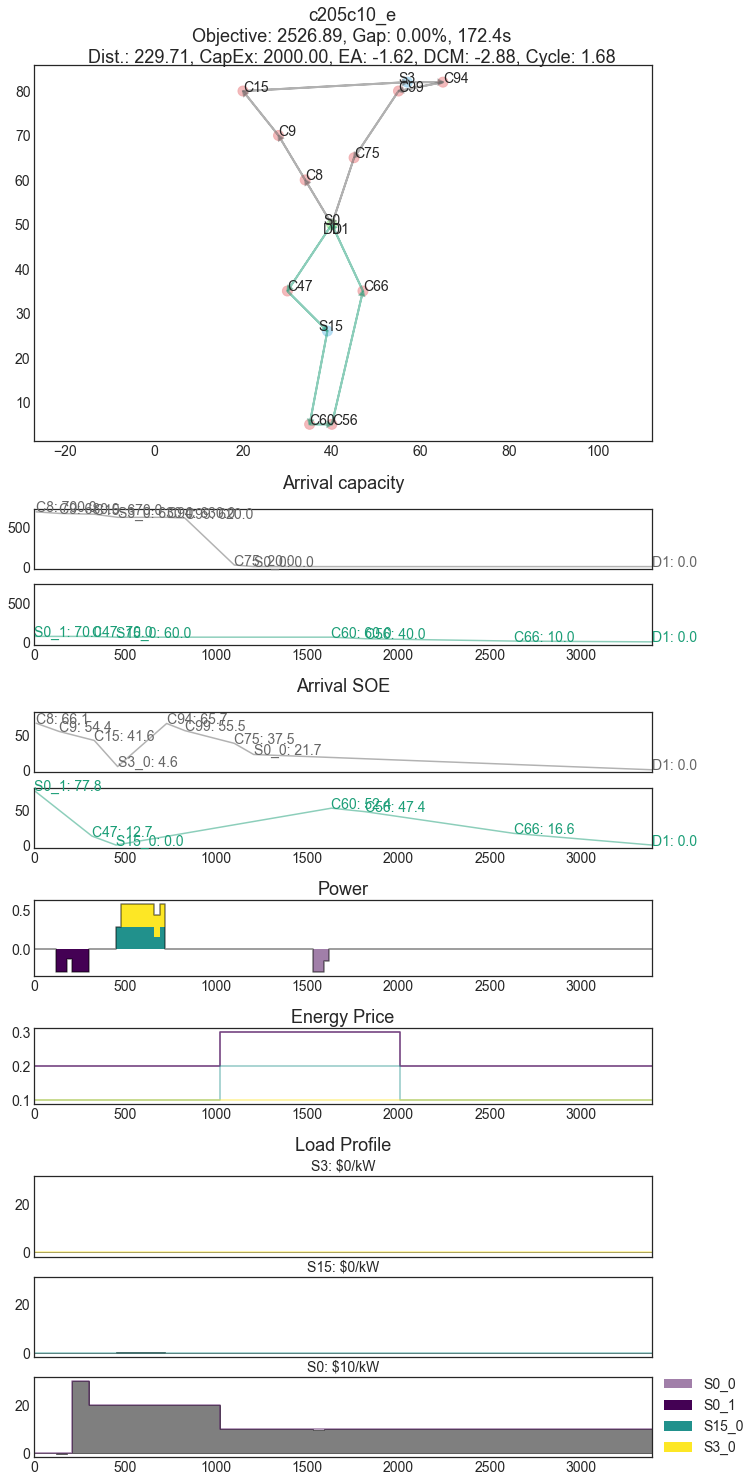

In [83]:
n_plots = 6
style_label = u'seaborn-white'

t_S = m.data['Parameters'].loc['t_S', 'value']
t_T = m.data['Parameters'].loc['t_T', 'value']
time = np.arange(0, t_T, t_S)

nt = len(traces)  # number of vehicles
stations = np.sort(xp['node'].unique())  # stations
ns = len(stations)
unique_stations = np.unique([m.s_2s[s] for s in stations])
nus = len(unique_stations)

gap = m.results['Problem'][0]
gap = round((gap['Upper bound'] - gap['Lower bound']) / gap['Upper bound'] * 100, 2)

# Load Profiles
# G = m.data['G'].copy()
G = pd.Series(m.instance.G.extract_values())
G = G.reset_index().pivot(index='level_1', columns='level_0', values=0)

# Energy Price
ce = pd.Series(m.instance.ce.extract_values())
ce = ce.reset_index().pivot(index='level_1', columns='level_0', values=0)
# ce = m.data['ce']

# Get colors for each vehicle
c = plt.get_cmap('Dark2')
colors = [c(tc) for tc in np.linspace(0, 1, len(traces))]

# Get colors for each station
c2 = plt.get_cmap('viridis')
colors2 = [c2(tc) for tc in np.linspace(0, 1, nus)]
us_color = {s: colors2[i] for i, s in enumerate(unique_stations)}
s_color = {s_: us_color[m.s_2s[s_]] for s_ in stations}
s_alpha = {s: 0 for s in unique_stations}
for s_, c in s_color.items():
    s = m.s_2s[s_]
    s_alpha[s] += 1/m.data['S']['instances'][s]
    c = list(c)
    c[-1] = s_alpha[s]
    s_color[s_] = tuple(c)

# fig, axs = plt.subplots(n_plots-1, 2, figsize=(10,10), sharex='col', 
#                         gridspec_kw={'width_ratios': [2, 1], 'height_ratios': [1, 1, 1, 1]})

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fweight = 2  # title fontweights
fdict = {'fontsize': MEDIUM_SIZE, 'fontweight' : fweight}  # subplot titles

plt.style.use(style_label)
fig = plt.figure(figsize=(10,20), num=style_label)

gs = GridSpec(n_plots, 1, width_ratios=[1], height_ratios=[n_plots-1, nt, nt, 1, 1, ns])
axs0 = fig.add_subplot(gs[0, 0])
axs1 = fig.add_subplot(gs[1, 0])
axs2 = fig.add_subplot(gs[2, 0], sharex=axs1)
axs3 = fig.add_subplot(gs[3, 0], sharex=axs1)
axs4 = fig.add_subplot(gs[4, 0], sharex=axs1)
axs5 = fig.add_subplot(gs[5, 0], sharex=axs1)

obj_breakdown = [m.total_distance(m.instance)(),
                 m.C_fleet_capital_cost(m.instance)(),
                 m.R_energy_arbitrage_revenue(m.instance)(), 
                 m.R_peak_shaving_revenue(m.instance)() - sum(G.max()[s] * cg for s, cg in m.instance.cg.extract_values().items()),
                 m.cycle_cost(m.instance)() + m.squeeze_cycle_cost(m.instance)()]

title = ''
title += '{}\n'.format(m.instance_name)
title += 'Objective: {:.2f}, Gap: {:.2f}%, {:.1f}s\n'.format(m.instance.obj.expr(), gap, m.results['Solver'][0]['Time'])
title += 'Dist.: {:.2f}, CapEx: {:.2f}, EA: {:.2f}, DCM: {:.2f}, Cycle: {:.2f}'.format(*obj_breakdown)
fig.suptitle(title, x=0.5, y=1.03, horizontalalignment='center', verticalalignment='top', size=MEDIUM_SIZE, weight=fweight)

a = 0.5

for i, n in enumerate('SDM'):
    # Plot the nodes
    axs0.scatter(m.data[n]['d_x'], m.data[n]['d_y'], c=[node_colors_rgba_tuple[n]]*len(m.data[n]), s=100)

    # Annotate the nodes
    for j, txt in enumerate(m.data[n].index):
        scale = 2
        if n == 'D':
            offset = [-scale, -scale]
        elif n == 'S':
            offset = [-scale, 0]
        else:
            offset = [0, 0]
        if txt == 'D1':
            offset = [0, -scale]
            
        axs0.annotate(txt, (m.data[n]['d_x'][j]+offset[0], m.data[n]['d_y'][j]+offset[1]))

# Plot the vehicle routes    
for ti, t in enumerate(traces):
    for ki, k in enumerate(t[:-1]):
        arrow_x = m.data['V_'].loc[t[ki], 'd_x']
        arrow_y = m.data['V_'].loc[t[ki], 'd_y']
        arrow_dx = m.data['V_'].loc[t[ki+1], 'd_x'] - arrow_x
        arrow_dy = m.data['V_'].loc[t[ki+1], 'd_y'] - arrow_y
        
        axs0.arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, alpha=a, linewidth=2,
                     length_includes_head=True, head_width=1, head_length=1, overhang=0, color=colors[ti])
    
    axs0.set_aspect('equal', adjustable='datalim')
    
    # Plot the vehicle states
    r = routes.loc[list(zip(t[:-1], t[1:]))]
    
    # Plot arrival capacity
    # create an inset axe in the current axe:
    ax1 = axs1.inset_axes([0, ti*1/nt, 1, .8*1/nt])
    ax1.plot(r['xw'], r['xq'], color=colors[ti], alpha=a) 
    for row in r.iterrows():
        ax1.annotate('{}: {:.1f}'.format(row[0][1], row[1]['xq']), xy=(row[1]['xw'], row[1]['xq']), color=colors[ti])
    ax1.get_shared_x_axes().join(ax1, axs1)
    ax1.get_shared_y_axes().join(ax1, axs1)
    ax1.set_xticklabels([])
    axs1.set_yticklabels([])
    axs1.set_xlim([0, t_T])
#     axs1.axis('off')
#     axs1.get_xaxis().set_visible(True)
#     axs1.grid(False)
    axs1.spines['right'].set_visible(False)
    axs1.spines['top'].set_visible(False)
    axs1.spines['bottom'].set_visible(False)
    axs1.spines['left'].set_visible(False)
    axs1.set_title('Arrival capacity', fontdict=fdict)   
    
    # Plot arrival SOE
    # create an inset axe in the current axe:
    ax2 = axs2.inset_axes([0, ti*1/nt, 1, .8*1/nt])
    ax2.plot(r['xw'], r['xa'], color=colors[ti], alpha=a)
    for row in r.iterrows():
        ax2.annotate('{}: {:.1f}'.format(row[0][1], row[1]['xa']), xy=(row[1]['xw'], row[1]['xa']), color=colors[ti])
    ax2.get_shared_x_axes().join(ax2, axs2)
    ax2.get_shared_y_axes().join(ax2, axs2)
    ax2.set_xticklabels([])
    axs2.set_yticklabels([])
    axs2.set_xlim([0, t_T])
    axs2.spines['right'].set_visible(False)
    axs2.spines['top'].set_visible(False)
    axs2.spines['bottom'].set_visible(False)
    axs2.spines['left'].set_visible(False)
    axs2.set_title('Arrival SOE', fontdict=fdict)
    
# Plot power
s = stations[0]
bott = pd.DataFrame(index=time)
bott['xp'] = 0
ind = xp[xp['node']==s]['t']
axs3.bar(ind, xp[xp['node']==s]['xp'], 
         label=s, width=t_S, align='edge', color=s_color[s])
for s2 in stations[1:]:
    ind = xp[xp['node']==s]['t']
    bott['xp'].loc[ind] += xp[xp['node']==s]['xp'].values
    axs3.bar(xp[xp['node']==s2]['t'], xp[xp['node']==s2]['xp'], bottom=bott.loc[xp[xp['node']==s2]['t']].values.reshape(-1),
             label=s2, width=t_S, align='edge', color=s_color[s2])
    s = s2
ind = xp[xp['node']==s]['t']
bott['xp'].loc[ind] += xp[xp['node']==s]['xp'].values

# axs3.hlines(bott['xp'], bott.index, bott.index+t_S)
bott.loc[t_T, 'xp'] = bott.loc[t_T-t_S, 'xp']
axs3.step(bott.index, bott['xp'], where='post', alpha=a, color='black')
axs3.set_title('Power', fontdict=fdict)
# axs3.legend(loc="upper left", ncol=round(ns/2), bbox_to_anchor=(0, -.25));

# Plot energy price
ce.loc[t_T] = ce.loc[t_T-t_S]
for s in stations:
    axs4.step(ce[m.s_2s[s]].index, ce[m.s_2s[s]], where='post', label='_nolegend_', alpha=a, color=s_color[s])
axs4.set_title('Energy Price', fontdict={'fontsize': MEDIUM_SIZE, 'fontweight' : fweight})      

# Plot load profiles
G.loc[t_T] = G.loc[t_T-t_S]

# calculate total power for each station
temp = xp.copy()
temp['s'] = temp['node'].apply(lambda x: m.s_2s[x])
total_power = temp.groupby(['s', 't']).sum()

for si, s in enumerate(unique_stations):
    # create an inset axe in the current axe:
    ax5 = axs5.inset_axes([0, si*1/nus, 1, .8*1/nus])
    ax5.step(G[s].index, G[s], where='post', label='_nolegend_', alpha=a, color=us_color[s])
    
    net_load = G[s].copy()
    net_load[total_power.loc[s].index] += total_power.loc[s]['xp']
    ax5.fill_between(net_load.index, net_load, step="post", alpha=a, color='black')
    
    ax5.get_shared_x_axes().join(ax5, axs5)
    ax5.get_shared_y_axes().join(ax5, axs5)
    ax5.set_xticklabels([])
    axs5.set_yticklabels([])
    axs5.set_xlim([0, t_T])
    ax5.title.set_text('{}: ${}/kW'.format(s, m.data['S'].loc[s, 'cg']))  

axs5.spines['right'].set_visible(False)
axs5.spines['top'].set_visible(False)
axs5.spines['bottom'].set_visible(False)
axs5.spines['left'].set_visible(False)
axs5.set_title('Load Profile', fontdict=fdict)  

fig.legend(loc="lower right", bbox_to_anchor=(1.05, 0.01)); # ncol=round(nus), , bbox_to_anchor=(1.05, .4)

fig.tight_layout()

In [82]:
xp

,node,t,state,xp
117,S0_1,120,1.0,-0.288184
118,S0_1,150,1.0,-0.288184
119,S0_1,180,1.0,-0.125555
120,S0_1,210,1.0,-0.288184
121,S0_1,240,1.0,-0.288184
122,S0_1,270,1.0,-0.288184
354,S15_0,450,1.0,0.288184
355,S15_0,480,1.0,0.288184
242,S3_0,480,1.0,0.288184
243,S3_0,510,1.0,0.288184


In [2784]:
routes

state           xw     xq         xa  from_d_x  from_d_y  to_d_x  \
from  to                                                                        
D0    S0_0     1.0     0.000000  700.0  77.750000        40        50      40   
      S0_1     1.0     0.000000  700.0  77.750000        40        50      40   
S0_0  C8       1.0    12.000000  700.0  66.088096        40        50      34   
C8    C9       1.0   138.000000  680.0  54.426192        34        60      28   
C9    C15      1.0   331.000000  670.0  41.619944        28        70      20   
C15   S3_0     1.0   510.000000   40.0   0.163985        20        80      57   
S0_1  C47      1.0   547.000000  700.0  56.437609        40        50      30   
S3_0  C94      1.0   728.000000   40.0  44.037184        57        82      65   
C94   C99      1.0  1130.000000   30.0  33.839145        65        82      55   
C47   C60      1.0  1312.000000  690.0  26.023796        30        35      35   
C99   C75      1.0  1419.000000   20.0  15.811388        55        80      45   
C60   C56      1.0  1497.000000   40.0  21.023796        35         5      40   
C56   S15_0    1.0  1608.023796   10.0   0.000000        40         5      39   
S15_0 C66      1.0  2953.000000   10.0  16.552945        39        26      47   
C75   D1       1.0  3390.000000    0.0   0.000000        45        65      40   
C66   D1       1.0  3390.000000    0.0   0.000000        47        35      40   

             to_d_y  
from  to             
D0    S0_0       50  
      S0_1       50  
S0_0  C8         60  
C8    C9         70  
C9    C15        80  
C15   S3_0       82  
S0_1  C47        35  
S3_0  C94        82  
C94   C99        80  
C47   C60         5  
C99   C75        65  
C60   C56         5  
C56   S15_0      26  
S15_0 C66        35  
C75   D1         50  
C66   D1         50

In [ ]:
i = 'S0_2'
j = 'D1'
m.instance.xw[i]() + m.instance.d[i, j] + m.instance.t_S() * sum(m.instance.xkappa[i, t] for t in m.instance.T)() - m.instance.xw[j]()

In [ ]:
m.data['d']

In [ ]:
routes

In [1383]:
m.instance.obj.expr()

2426.4937076977776

In [1384]:
sum(sum(sum(m.instance.ce.extract_values()[(s,t)] * m.instance.xp.extract_values()[(i,t)] * m.instance.xkappa.extract_values()[(i,t)] for t in m.instance.T.data()) for i in m.instance.Smap.extract_values()[s]) for s in m.instance.S.data())

1.096728461629606

In [1385]:
xp.groupby('node').describe()

t                                                      state       \
      count   mean        std    min    25%    50%    75%    max count mean   
node                                                                          
S0_0    3.0   30.0  10.000000   20.0   25.0   30.0   35.0   40.0   3.0  1.0   
S0_1    5.0   20.0  15.811388    0.0   10.0   20.0   30.0   40.0   5.0  1.0   
S0_2    1.0  220.0        NaN  220.0  220.0  220.0  220.0  220.0   1.0  1.0   
S0_3    7.0  190.0  21.602469  160.0  175.0  190.0  205.0  220.0   7.0  1.0   
S13_0   3.0   80.0  10.000000   70.0   75.0   80.0   85.0   90.0   3.0  1.0   
S1_0    3.0  130.0  10.000000  120.0  125.0  130.0  135.0  140.0   3.0  1.0   

       ...              xp                                                    \
       ...  75%  max count      mean       std       min       25%       50%   
node   ...                                                                     
S0_0   ...  1.0  1.0   3.0  0.636832  2.319827 -2.040816 -0.065160  1.910497   
S0_1   ...  1.0  1.0   5.0  1.156031  1.793228 -2.040816  1.698522  2.040816   
S0_2   ...  1.0  1.0   1.0 -1.400839       NaN -1.400839 -1.400839 -1.400839   
S0_3   ...  1.0  1.0   7.0 -0.398220  2.063743 -2.040816 -2.040816 -2.040816   
S13_0  ...  1.0  1.0   3.0  2.021000  0.034323  1.981367  2.011092  2.040816   
S1_0   ...  1.0  1.0   3.0  2.021000  0.017161  2.011092  2.011092  2.011092   

                           
            75%       max  
node                       
S0_0   1.975657  2.040816  
S0_1   2.040816  2.040816  
S0_2  -1.400839 -1.400839  
S0_3   1.667455  2.040816  
S13_0  2.040816  2.040816  
S1_0   2.025954  2.040816  

[6 rows x 24 columns]

In [776]:
test = [xp.set_index('node').loc[n,'state'] * v for n, v in routes.reset_index('to')['state'].iteritems() if n in xp['node'].unique()]